# Importing Libraries, Setting Helper Fucnctions and Reading in Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

import math
import os
import statistics
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import anderson

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer


# an initial clean-up function
def clean_up(df,ds='rawdata1'):
    df["YEAR"] = df["YEAR"].astype('str')
    df["MONTH"] = df["MONTH"].astype('str')
    df["DATE"] = df["MONTH"] + '-' + df["YEAR"]
    df["DATE"] =  pd.to_datetime(df["DATE"], format="%m-%Y")
    df = df.drop(['YEAR','MONTH'], axis=1)
    df = df.set_index('DATE')
    
    df["STORE"] = df["STORE"].astype('str')
    df["DAYPART"] = df["DAYPART"].astype('str')
      
    if ds == 'rawdata1':
        df["CATEGORY_ID"] = df["CATEGORY_ID"].astype('str')
    return df


# a function to produce pivot tables
def piv_fun(rawdata_1,rawdata_2, piv_type='store'):
    
    daypart_list = ['B','L','D']
    category_list = ['10','15','20','25','30','40','45','50','55','60','99']
    helper_list = ['B','L','D','store']

    if piv_type=='store':
        rawdata_1_filt = rawdata_1
        rawdata_2_filt = rawdata_2
    elif piv_type in daypart_list:
        rawdata_1_filt = rawdata_1[rawdata_1['DAYPART']==piv_type]
        rawdata_2_filt = rawdata_2[rawdata_2['DAYPART']==piv_type]
    else:
        rawdata_1_filt = rawdata_1[rawdata_1['CATEGORY_ID']==piv_type]
  
    # revenue pivot
    rawdata_1_filt_rev = pd.pivot_table(rawdata_1_filt, values='REVENUE_NET', index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
    rawdata_1_filt_rev.columns.name = None

    # quantity pivot
    rawdata_1_filt_quan = pd.pivot_table(rawdata_1_filt, values='QTY', index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
    rawdata_1_filt_quan.columns.name = None

    # average price pivot
    rawdata_1_filt_avgprice = pd.pivot_table(rawdata_1_filt, values='Avg_Price', index=['DATE'],
                       columns=['STORE'], aggfunc="mean")
    rawdata_1_filt_avgprice.columns.name = None
    rawdata_1_filt_avgprice = round(rawdata_1_filt_avgprice,2)

    # customer count pivot
    if piv_type in helper_list:
        rawdata_2_custcnt = pd.pivot_table(rawdata_2_filt, values='CUSTOMER_COUNT', index=['DATE'],
                           columns=['STORE'], aggfunc="sum")
        rawdata_2_custcnt.columns.name = None
    else:
        rawdata_2_custcnt = None
    
    return rawdata_1_filt_rev,rawdata_1_filt_quan,rawdata_2_custcnt,rawdata_1_filt_avgprice

    
def plot_fun2(df,i,store,ax):
    
    if i==0:
        ax.plot(df[store])
        ax.set_ylim(bottom = 0)
        ax.set_title('Total Revenues')
        ax.tick_params(axis='x', rotation=45)

    if i==1:
        ax.plot(df[store])
        ax.set_ylim(bottom = 0)
        ax.set_title('Total Quantity')
        ax.tick_params(axis='x', rotation=45)
        
    if i+1==3:
        ax.plot(df[store])
        ax.set_title('Average Prices')
        ax.tick_params(axis='x', rotation=45)            
        

# Settings
pd.set_option('display.max_columns', 50)
os.chdir('C:/Users/darre/Documents/Restaurant Pricing')

In [2]:
def plot_fun1(df,store,ax,**kwargs):
    
    # creating dictionaries to help with subplot titles
    dict_daypart = {0: 'Breakfast',
        1: 'Lunch',
        2: 'Dinner'}
    
    dict_category = {0: 'BREAKFAST',
        1: 'SENIORS MEALS',
        2: 'DINNER',
        3: 'DINNER ALA',
        4: 'LUNCH',
        5: 'SOUP SALAD',
        6: 'KIDS',
        7: 'BEVERAGE',
        8: 'DESSERTS',
        9: 'BRKFST ALA',
       }
    
    # plotting Revenue
    ax.plot(df[0][store],label = 'Net Revenue ($)')
    ax.set_ylim(bottom = 0)

    # plotting Quantity
    ax.plot(df[1][store],label = 'Quantity (units)')

    # plotting Customer Counts
    ax.plot(df[2][store],label = 'Customer Count (units)')
    
    ax.tick_params(axis='x', rotation=45)
    
    # plotting Average Price / Unit
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color='tab:red'
    ax2.plot(df[3][store],color=color,linestyle = '--',label='Average Price / Unit ($)')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom = 0)

    # attending subplot titles
    if kwargs.get('type')=='dp':
        i = kwargs.get('plot_num')
        title = dict_daypart.get(i)
        ax.set_title(title,loc='left')
    if kwargs.get('type')=='cat':
        i = kwargs.get('plot_num')
        title = dict_category.get(i)
        ax.set_title(title)    
    
    # attending legend
    if kwargs.get('type')=='dp':  
        ax.legend(bbox_to_anchor=(1.43,0.9),
          frameon=True)
        ax2.legend(bbox_to_anchor=(1.43,0.4),
              frameon=True)
    elif kwargs.get('type')=='cat':
        pass
    else:
        ax.legend(bbox_to_anchor=(1.52,0.9),
          frameon=True)
        ax2.legend(bbox_to_anchor=(1.52,0.6),
          frameon=True)

In [3]:
rawdata1 = pd.read_csv('RAWDATA1.csv')
rawdata2 = pd.read_csv('RAWDATA2.csv')
rawdata3 = pd.read_csv('RAWDATA3.csv')
rawdata4 = pd.read_csv('RAWDATA4.csv')

# Clean-Up on Data

## RawDate1

In [4]:
rawdata1.head(3)

,YEAR,MONTH,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
0,2018,1,1,B,10,11700,2050
1,2018,1,1,D,10,3700,570
2,2018,1,1,L,10,7700,1270


In [5]:
rawdata1 = clean_up(rawdata1,ds='rawdata1')
rawdata1.head(3)

,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
DATE,,,,,
2018-01-01,1,B,10,11700,2050
2018-01-01,1,D,10,3700,570
2018-01-01,1,L,10,7700,1270


In [6]:
rawdata1['Avg_Price'] = round(rawdata1['REVENUE_NET'] / rawdata1['QTY'],2)
rawdata1.head(3)

,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY,Avg_Price
DATE,,,,,,
2018-01-01,1,B,10,11700,2050,5.71
2018-01-01,1,D,10,3700,570,6.49
2018-01-01,1,L,10,7700,1270,6.06


## RawDate2

In [7]:
rawdata2.head(3)

,STORE,DAYPART,YEAR,MONTH,CUSTOMER_COUNT
0,1,B,2018,1,3312
1,1,B,2018,2,3366
2,1,B,2018,3,4116


In [8]:
rawdata2 = clean_up(rawdata2,ds='rawdata2')
rawdata2.head(3)

,STORE,DAYPART,CUSTOMER_COUNT
DATE,,,
2018-01-01,1,B,3312
2018-02-01,1,B,3366
2018-03-01,1,B,4116


## RawDate3

In [9]:
rawdata3.head(3)

,STORE,CITY,STATE,NAME,AREA,REGIONAL_DIRECTOR,REGION
0,1,RIO GRANDE,OH,RIO GRANDE,1,"GREEN, JOE","GRANDE, OH"
1,2,CHILLICOTHE,OH,CHILLICOTHE,26,"YELLOW, JAMES","CHILLICOTHE, OH"
2,3,COLUMBUS,OH,ROUTE 161,7,"YELLOW, JAMES","COLUMBUS, OH"


## RawDate4

In [10]:
rawdata4.head(3)

,CATEGORY_ID,CATEGORY_DESC,COMMENTS
0,10,BREAKFAST,Breakfast items
1,15,SENIORS MEALS,Seniors Meals
2,20,DINNER,Dinner items


## Creating Pivot Tables

In [11]:
# store level pivots
df_store_list = piv_fun(rawdata1,rawdata2, piv_type='store')

# daypart level pivots
df_brkfst_list = piv_fun(rawdata1,rawdata2, piv_type='B')
df_lnch_list = piv_fun(rawdata1,rawdata2, piv_type='L')
df_dnr_list = piv_fun(rawdata1,rawdata2, piv_type='D')

daypart_list = [df_brkfst_list,df_lnch_list,df_dnr_list]

# category level pivots
df_10_list = piv_fun(rawdata1,rawdata2, piv_type='10')
df_15_list = piv_fun(rawdata1,rawdata2, piv_type='15')
df_20_list = piv_fun(rawdata1,rawdata2, piv_type='20')
df_25_list = piv_fun(rawdata1,rawdata2, piv_type='25')
df_30_list = piv_fun(rawdata1,rawdata2, piv_type='30')
df_40_list = piv_fun(rawdata1,rawdata2, piv_type='40')
df_45_list = piv_fun(rawdata1,rawdata2, piv_type='45')
df_50_list = piv_fun(rawdata1,rawdata2, piv_type='50')
df_55_list = piv_fun(rawdata1,rawdata2, piv_type='55')
df_60_list = piv_fun(rawdata1,rawdata2, piv_type='60')
df_99_list = piv_fun(rawdata1,rawdata2, piv_type='99')

# Plotting Data

## Store 1

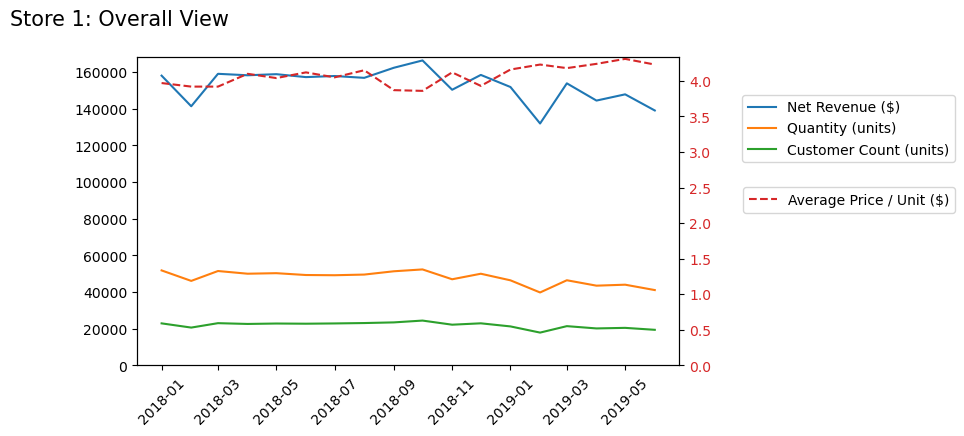

In [25]:
store = '10'
fig = plt.figure(figsize=(7,4)) # creating the figure object
ax = fig.add_subplot()
fig.suptitle('Store 1: Overall View', # title for the figure
              fontsize = 15,
              x = 0.1,
              y = 1.0)

plot_fun1(df_store_list,store,ax)

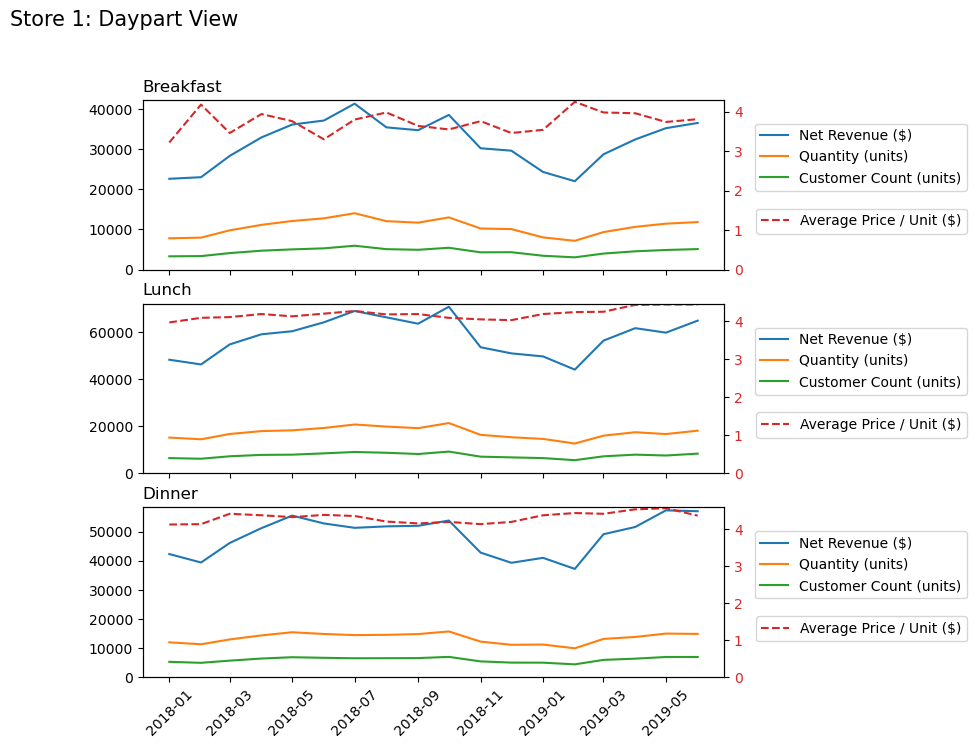

In [13]:
fig, axes = plt.subplots(3,1, figsize=(7.5,7.5),sharex=True)
axes = axes.flatten()
fig.suptitle('Store 1: Daypart View', # title for the figure
              fontsize = 15,
              x = 0.1,
              y = 1.0)

for i,axe in enumerate(axes):
    plot_fun1(daypart_list[i],store,axe,plot_num = i,type='dp')

In [14]:
df_store_list[0]

,1,10,2,3,4,5,6,7,8,9
DATE,,,,,,,,,,
2018-01-01,113200,158000,173900,124900,78300,173300,146600,206900,105400,99900
2018-02-01,108700,141300,161800,124700,75700,162300,136600,184700,94500,94200
2018-03-01,129200,159000,177400,148700,77700,167800,148500,198100,105500,103400
2018-04-01,143200,158200,174200,146500,74800,165900,147400,201400,105700,102500
2018-05-01,152000,158800,180400,135200,76700,166700,150200,206400,112000,103000
2018-06-01,154100,157200,178000,141000,72400,161600,151800,200500,109200,105500
2018-07-01,161600,157800,187900,162300,82400,163600,167700,206100,121100,113500
2018-08-01,153500,156800,183100,147400,74400,163400,148100,213900,116700,106200
2018-09-01,150300,162300,191500,138600,75600,166600,148100,214700,107700,100300


In [15]:
df_store_list[1]

,1,10,2,3,4,5,6,7,8,9
DATE,,,,,,,,,,
2018-01-01,35040,51750,55900,40300,25310,56070,47740,69470,34000,31480
2018-02-01,33800,46030,51840,39930,24250,52370,44180,62080,30140,29630
2018-03-01,39530,51420,56450,46840,24900,54420,47810,66290,33310,32480
2018-04-01,43500,49950,55180,46320,23600,53330,47020,66720,33400,32430
2018-05-01,45860,50240,56760,43160,24380,53260,47580,68090,35350,32100
2018-06-01,46940,49240,56710,44690,23440,52360,48130,66560,34780,33340
2018-07-01,49310,49120,59680,51020,26040,52750,52780,68420,39020,35580
2018-08-01,46540,49480,58160,47020,23800,52960,46530,70750,37730,33300
2018-09-01,45760,51280,60990,44080,24520,53820,46800,70860,34720,31490


In [16]:
df_store_list[3]

,1,10,2,3,4,5,6,7,8,9
DATE,,,,,,,,,,
2018-01-01,3.77,3.97,4.09,3.99,3.97,4.06,3.94,3.78,3.68,4.11
2018-02-01,4.13,3.92,4.04,4.13,3.97,4.12,3.79,3.63,3.85,3.85
2018-03-01,4.00,3.92,4.08,4.17,3.96,4.00,3.84,3.93,3.75,3.92
2018-04-01,4.17,4.10,4.03,4.03,3.94,4.17,3.89,4.02,3.88,3.71
2018-05-01,4.07,4.04,4.23,4.00,3.97,4.14,3.93,3.88,3.77,4.27
2018-06-01,3.96,4.12,4.03,4.03,3.70,4.20,3.92,4.13,3.80,4.00
2018-07-01,4.14,4.05,3.97,4.03,3.94,4.03,4.02,4.14,4.00,4.16
2018-08-01,4.12,4.15,4.16,4.02,3.67,4.09,3.94,4.00,4.09,4.00
2018-09-01,3.99,3.87,4.03,3.85,3.62,3.93,3.92,4.25,3.83,3.92


### Breakfast Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_brkfst_list[i],i,store, axe)

### Lunch Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_lnch_list[i],i,store, axe)

### Dinner Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_dnr_list[i],i,store, axe)

### 10 Level

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun2(df_10_list[i],i,store, axe)